# Tabular Playground Series SEP 2022

- The competing Kaggle merchandise stores we saw in January's Tabular Playground are at it again. This time, they're selling books!

- The task for this month's competitions is a bit more complicated. Not only are there six countries and four books to forecast, but you're being asked to forecast sales during the tumultuous year 2021. Can you use your data science skills to predict book sales when conditions are far from the ordinary?

### What is Playground Series ?

Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, we've launched many Playground competitions that are more approachable than our Featured competitions and thus, more beginner-friendly.

The goal of these competitions is to provide a fun and approachable-for-anyone tabular dataset to model. These competitions are a great choice for people looking for something in between the Titanic Getting Started competition and the Featured competitions. If you're an established competitions master or grandmaster, these probably won't be much of a challenge for you; thus, we encourage you to avoid saturating the leaderboard.

For each monthly competition, we'll be offering Kaggle Merchandise for the top three teams. And finally, because we want these competitions to be more about learning, we're limiting team sizes to 3 individuals.

## Purpose of the Model

- Make a model that predict "num_sold"
- Test data is in 2021, but the train data are from 2017~2020

# Import Libraries

In [1]:
# 데이터 분석
import pandas as pd
import numpy as np
# 데이터 분석(시각화)
import matplotlib.pyplot as plt 
import seaborn as sns 
# ML 모델링 
from sklearn.model_selection import train_test_split
import skimage
import shap
import xgboost

# RMSE 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import tqdm

# Load dataset

- Load train data 

In [2]:
train_data = pd.read_csv('./dataset/train.csv')
train_data

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...,...
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135


# Data Preprocessing

1. Check Null dataset and do preprocessing
2. Check the distribution of the data. 

## Check Missing Values

- use pandas isnull()

In [3]:
train_data.isnull().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

## Check Data Type 

- 1. Check data type
- 2. Check Unique data
- 3. Do one-hot encoding or label encoding

In [4]:
train_data.dtypes

row_id       int64
date        object
country     object
store       object
product     object
num_sold     int64
dtype: object

I figure out data, country, store, product data are object.
So I will preprocess four columns of data

### Date Column Preprocessing 

In [5]:
day = []
month = []
year = []

for i in tqdm.notebook.tqdm(range(len(train_data))):
    temp = str(train_data.iloc[i]['date'])
    year.append(int(temp[:4]))
    month.append(int(temp[5:7]))
    day.append(int(temp[8:]))
    
train_data['day']= day
train_data['month'] = month
train_data['year'] = year

  0%|          | 0/70128 [00:00<?, ?it/s]

In [6]:
train_data = train_data.drop('date',axis=1)

### Country, Store, Product Column Preprocessing

In [7]:
unique_dict = {
    'country': dict(),
    'store': dict(),
    'product': dict()
}


for i in tqdm.notebook.tqdm(range(len(train_data))):
    temp = train_data.iloc[i]
    
    if temp['country'] in unique_dict['country'] : 
        unique_dict['country'][temp['country']] +=1
    else :
        unique_dict['country'][temp['country']] = 1
        
    if temp['store'] in unique_dict['store'] : 
        unique_dict['store'][temp['store']] += 1
    else : 
        unique_dict['store'][temp['store']] = 1
        
    if temp['product'] in unique_dict['product'] :
        unique_dict['product'][temp['product']] += 1
    else : 
        unique_dict['product'][temp['product']] = 1


  0%|          | 0/70128 [00:00<?, ?it/s]

In [8]:
for col in unique_dict : 
    print("<"+col+">")
    for key in unique_dict[col] :
        print(key ,":", unique_dict[col][key])
    print('----------------------------------------------')

<country>
Belgium : 11688
France : 11688
Germany : 11688
Italy : 11688
Poland : 11688
Spain : 11688
----------------------------------------------
<store>
KaggleMart : 35064
KaggleRama : 35064
----------------------------------------------
<product>
Kaggle Advanced Techniques : 17532
Kaggle Getting Started : 17532
Kaggle Recipe Book : 17532
Kaggle for Kids: One Smart Goose : 17532
----------------------------------------------


In [9]:
# country
encoder_country = LabelEncoder()
encoder_country .fit(train_data['country'])
train_data['country'] = encoder_country.transform(train_data['country'])
# store
encoder_store = LabelEncoder()
encoder_store.fit(train_data['store'])
train_data['store'] = encoder_store.transform(train_data['store'])
# product
encoder_product = LabelEncoder()
encoder_product.fit(train_data['product'])
train_data['product'] = encoder_product.transform(train_data['product'])

In [10]:
train_data

,row_id,country,store,product,num_sold,day,month,year
0,0,0,0,0,663,1,1,2017
1,1,0,0,1,615,1,1,2017
2,2,0,0,2,480,1,1,2017
3,3,0,0,3,710,1,1,2017
4,4,0,1,0,240,1,1,2017
...,...,...,...,...,...,...,...,...
70123,70123,5,0,3,614,31,12,2020
70124,70124,5,1,0,215,31,12,2020
70125,70125,5,1,1,158,31,12,2020
70126,70126,5,1,2,135,31,12,2020


# EDA (Exploratory Data Analysis)

- elimniate row_id, because it doesn't have correlation with data

In [11]:
train_data = train_data.drop('row_id',axis=1)

In [12]:
train_data.describe()

,country,store,product,num_sold,day,month,year
count,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000
mean,2.500000,0.500000,1.500000,194.296986,15.729637,6.522930,2018.501027
std,1.707837,0.500004,1.118042,126.893874,8.800155,3.448728,1.118348
min,0.000000,0.000000,0.000000,19.000000,1.000000,1.000000,2017.000000
25%,1.000000,0.000000,0.750000,95.000000,8.000000,4.000000,2018.000000
50%,2.500000,0.500000,1.500000,148.000000,16.000000,7.000000,2019.000000
75%,4.000000,1.000000,2.250000,283.000000,23.000000,10.000000,2020.000000
max,5.000000,1.000000,3.000000,986.000000,31.000000,12.000000,2020.000000


array([[<AxesSubplot:title={'center':'country'}>,
        <AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'product'}>],
       [<AxesSubplot:title={'center':'num_sold'}>,
        <AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

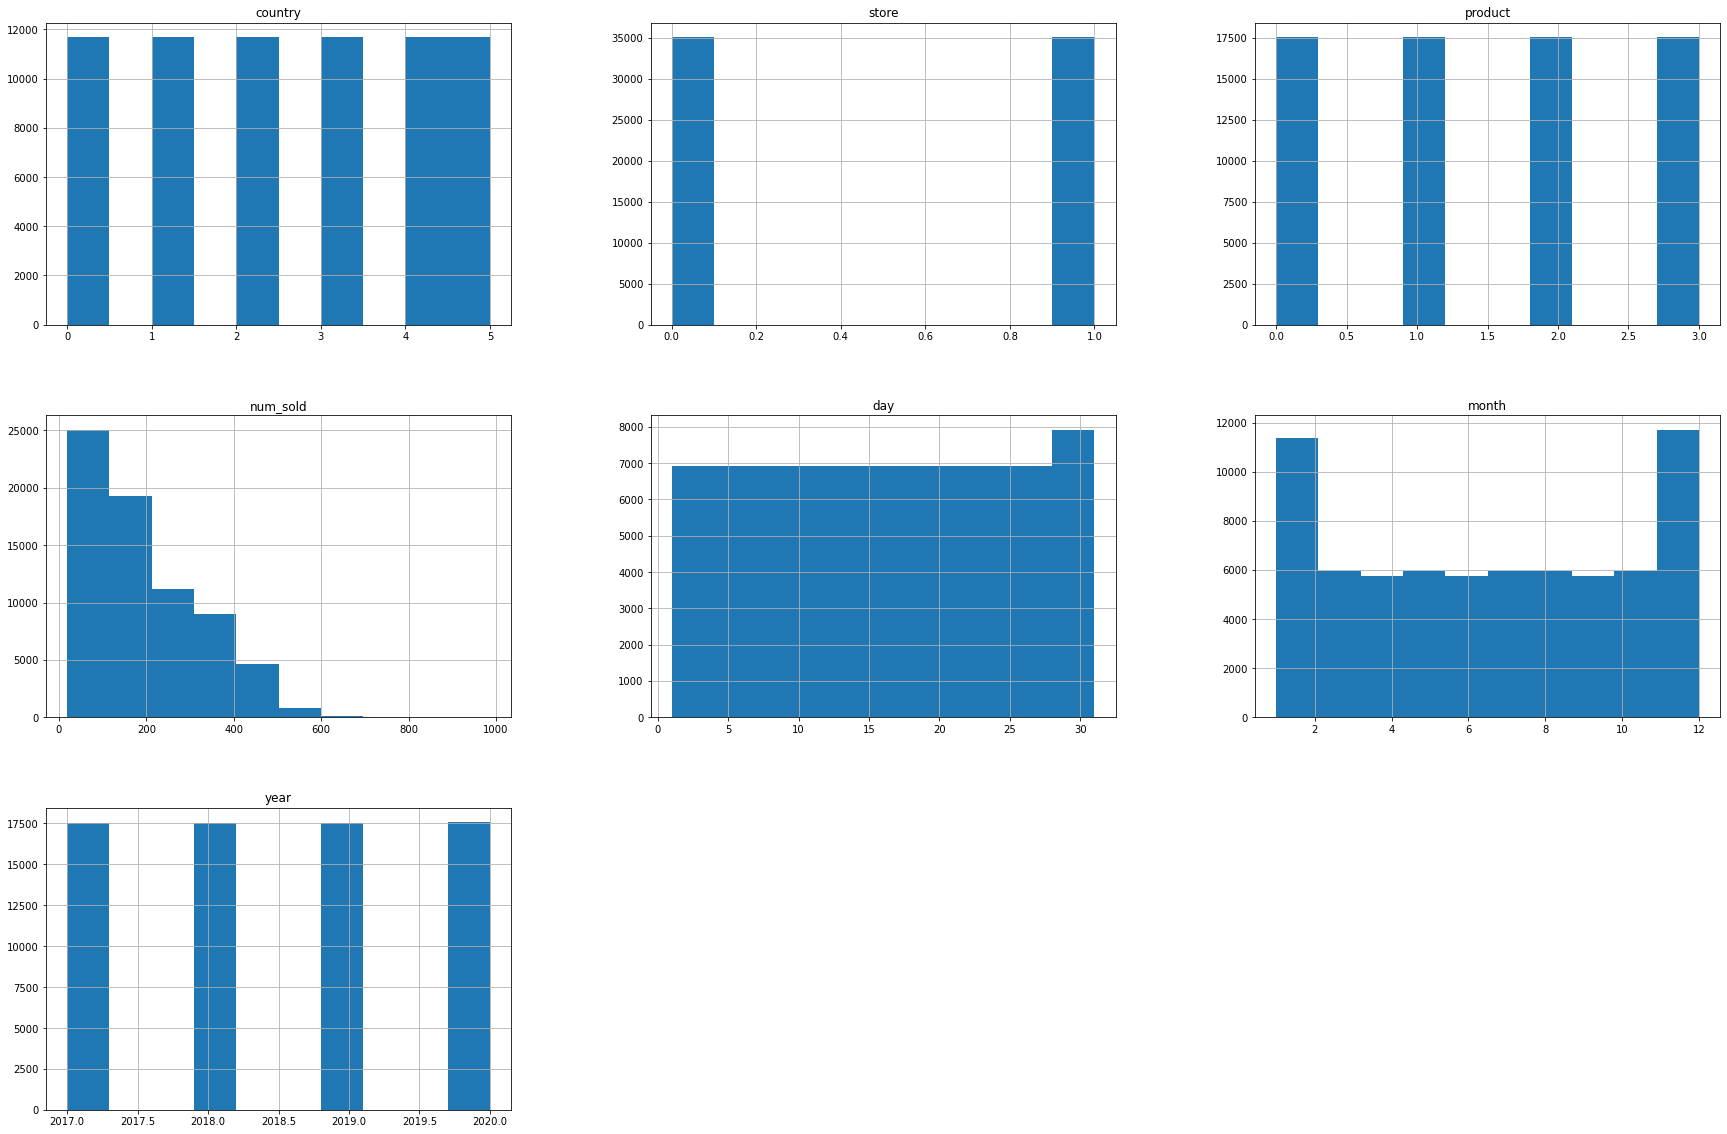

In [13]:
train_data.hist(figsize=((30,20)))

## Check Correlation

- There is very little correlation between 'num_sold' and other columns

<AxesSubplot:>

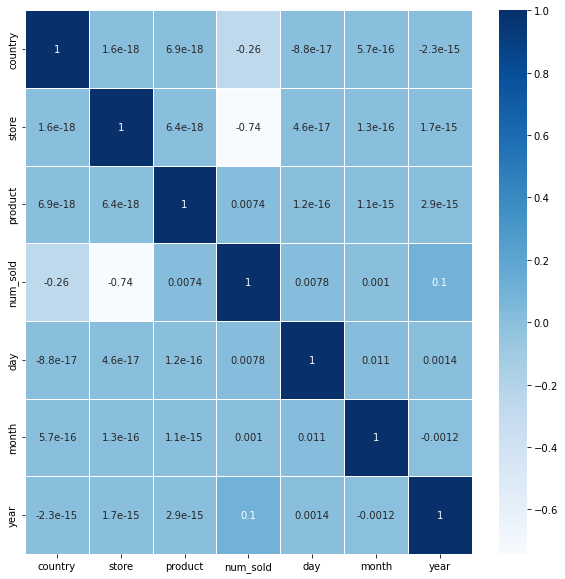

In [14]:
# 선형성 확인
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), linewidths=.5, cmap = 'Blues', annot=True)

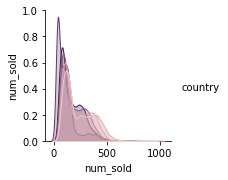

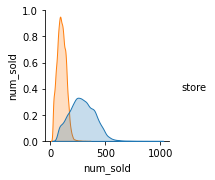

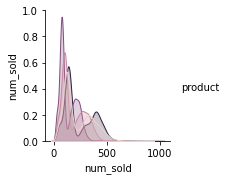

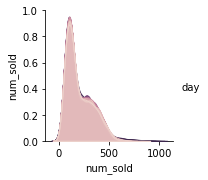

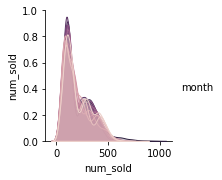

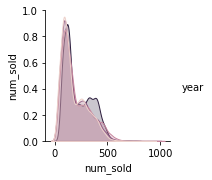

In [15]:
columns=list(train_data.columns)

for item in columns : 
    if item != 'num_sold':
        sns.pairplot(train_data[['num_sold',item]], hue=item)

- store, product에서의 차이가 가장 큰 영향을 미치는 것임을 알 수 있습니다. 

# Modeling

- Using Xgboost

In [16]:
train_x = train_data.drop('num_sold',axis=1)
train_y = train_data['num_sold']

In [17]:
train_x.shape, train_y.shape

((70128, 6), (70128,))

In [18]:
xgb_model = xgboost.XGBRegressor(learning_rate=0.2,
                                 n_estimators=1000,
                                 max_depth=12,
                                 min_child_weight=1,
                                 gamma=0,
                                 colsample_bytree = 0.7,
                                 subsample=0.75,
                                 objective= 'reg:squarederror',
                                 nthread=-1,
                                 reg_alpha = 1e-5,
                                 scale_pos_weight=1,
                                 seed=2011)
xgb_model.fit(train_x,train_y)
predict = xgb_model.predict(train_x )
print("RMSE: {}".format((mean_squared_error(predict, train_y)**0.5)))

RMSE: 9.875355609637056


### Xgboost Feature Importance
- Xgboost offers a function that can figure out Feature importance. You can use this function figure out which variable has an useful impacts on the function. 
  - Gain : How much the variables reduce loss function 
  - Weight : How many times the variables are used to separate datas
  - Cover : The number of samples are related to Features
- Disadvantage : Because these have different point of views it is hard to explain. (low consistency)

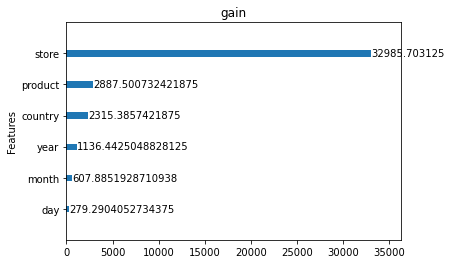

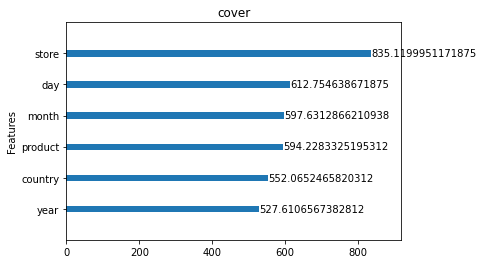

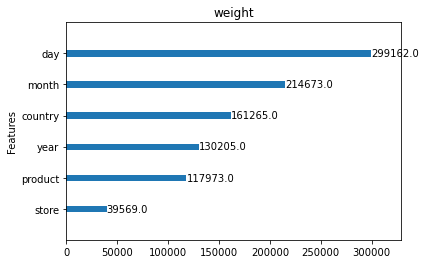

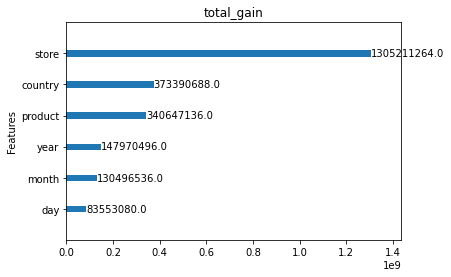

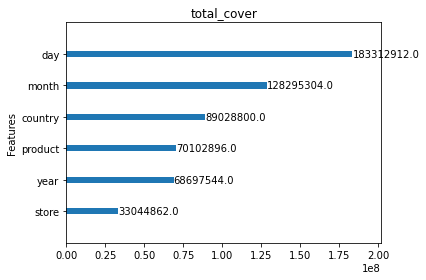

In [19]:
xgboost.plot_importance(xgb_model, importance_type = 'gain', title='gain', xlabel='', grid=False)
xgboost.plot_importance(xgb_model, importance_type = 'cover', title='cover', xlabel='', grid=False)
xgboost.plot_importance(xgb_model, importance_type = 'weight', title='weight', xlabel='', grid=False)
xgboost.plot_importance(xgb_model, importance_type = 'total_gain', title='total_gain', xlabel='', grid=False)
xgboost.plot_importance(xgb_model, importance_type = 'total_cover', title='total_cover', xlabel='', grid=False)
plt.tight_layout()
plt.show()

### Shap Value

- Shap value 는 consistency를 보장함
- 특정 관측치 별로 중요도를 볼 수 있음
- 다양한 변수들의 조합을 통해 시각화를 할 수 있어 파악하기 쉬움

In [20]:
explainer = shap.TreeExplainer(xgb_model) # 트리 모델 Shap Value 계산 객체 지정
shap_values = explainer.shap_values(train_x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [21]:
shap.initjs() # 자바스크립트 초기화 (그래프 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], train_x.iloc[1,:]) 
# 첫 번째 검증 데이터 인스턴스에 대해 Shap Value를 적용하여 시각화
# 빨간색이 영향도가 높으며, 파란색이 영향도가 낮음

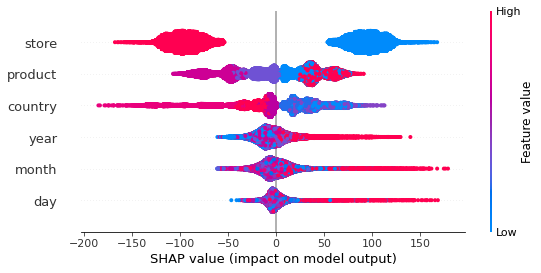

In [22]:
shap.summary_plot(shap_values, train_x)

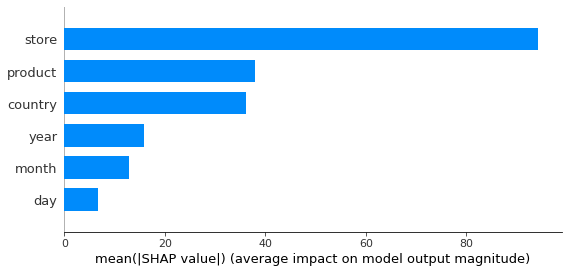

In [23]:
shap.summary_plot(shap_values, train_x, plot_type = "bar") # 각 변수에 대한 Shap Values의 절대값으로 중요도 파악

# HyperParameter Tuning

- Xgboost has a lot of parameters for training. So we divided some steps to enhance the performance of models

## Step1. 정확도 향상
- max_depth, min_child_weight, n_estimator 하이퍼파라미터 튜닝

In [28]:
# 정확도 향상
from sklearn.model_selection import GridSearchCV

params = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,2),
 'n_estimators':range(100,1100,100)
}
grid_xgb = GridSearchCV(estimator = xgboost.XGBRegressor(learning_rate=0.1, 
                                                         n_estimators=1000, 
                                                         max_depth=5, 
                                                         min_child_weight=1, 
                                                         gamma=0, 
                                                         subsample=0.8, 
                                                         colsample_bytree=0.8,
                                                         objective= 'reg:squarederror', 
                                                         nthread=-1, 
                                                         scale_pos_weight=1, 
                                                         seed=2019),
                        param_grid = params, n_jobs=-1)
grid_xgb.fit(train_x,train_y)
predict=grid_xgb.predict(train_x)
print("RMSE:",mean_squared_error(train_y, predict)**0.5)
print(grid_xgb.best_params_, grid_xgb.best_score_)

RMSE: 20.813931430881677
{'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200} 0.9456978304164373


### Step2
- gamma 하이퍼파라미터 튜닝

In [29]:
from sklearn.model_selection import GridSearchCV

params = {
    'gamma':[i/10.0 for i in range(0,5)]
}
grid_xgb = GridSearchCV(estimator = xgboost.XGBRegressor(learning_rate=0.1, 
                                                         n_estimators=200, 
                                                         max_depth=6, 
                                                         min_child_weight=3, 
                                                         gamma=0, 
                                                         subsample=0.8, 
                                                         colsample_bytree=0.8,
                                                         objective= 'reg:squarederror', 
                                                         nthread=-1, 
                                                         scale_pos_weight=1, 
                                                         seed=2019),
                        param_grid = params, n_jobs=-1)
grid_xgb.fit(train_x,train_y)
predict=grid_xgb.predict(train_x)
print("RMSE:",mean_squared_error(train_y, predict)**0.5)
print(grid_xgb.best_params_, grid_xgb.best_score_)

RMSE: 20.813930999399076
{'gamma': 0.3} 0.9457351998215728


### Step3
- colsample_bytree, subsample 하이퍼파라미터 튜닝

In [30]:
from sklearn.model_selection import GridSearchCV

params = {
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'subsample':[i/100.0 for i in range(40,100)],
    
}
grid_xgb = GridSearchCV(estimator = xgboost.XGBRegressor(learning_rate=0.1, 
                                                         n_estimators=200, 
                                                         max_depth=6, 
                                                         min_child_weight=3, 
                                                         gamma=0.3, 
                                                         subsample=0.8, 
                                                         colsample_bytree=0.8,
                                                         objective= 'reg:squarederror', 
                                                         nthread=-1, 
                                                         scale_pos_weight=1, 
                                                         seed=2019),
                        param_grid = params, n_jobs=-1)
grid_xgb.fit(train_x,train_y)
predict=grid_xgb.predict(train_x)
print("RMSE:",mean_squared_error(train_y, predict)**0.5)
print(grid_xgb.best_params_, grid_xgb.best_score_)

RMSE: 20.84018388784953
{'colsample_bytree': 0.7, 'subsample': 0.91} 0.9468058964337404


### Step 4. 
- Regularization Parameter 튜닝

In [31]:
from sklearn.model_selection import GridSearchCV

params = {

    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
grid_xgb = GridSearchCV(estimator = xgboost.XGBRegressor(learning_rate=0.1, 
                                                         n_estimators=200, 
                                                         max_depth=6, 
                                                         min_child_weight=3, 
                                                         gamma=0.3, 
                                                         colsample_bytree = 0.7,
                                                         subsample=0.91,
                                                         objective= 'reg:squarederror', 
                                                         nthread=-1, 
                                                         scale_pos_weight=1, 
                                                         seed=2019),
                        param_grid = params,n_jobs=-1)
grid_xgb.fit(train_x,train_y)
predict=grid_xgb.predict(train_x)
print("RMSE:",mean_squared_error(train_y, predict)**0.5)
print(grid_xgb.best_params_, grid_xgb.best_score_)

RMSE: 20.84019384987194
{'reg_alpha': 0.01} 0.9468316573205678


# Learning Rate 
- learning_rate 하이퍼 파라미터 튜닝

In [32]:
params = {
    'learning_rate':[0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
grid_xgb = GridSearchCV(estimator = xgboost.XGBRegressor(learning_rate=0.1, 
                                                         n_estimators=200, 
                                                         max_depth=6, 
                                                         min_child_weight=3, 
                                                         gamma=0.3, 
                                                         colsample_bytree = 0.7,
                                                         subsample=0.91,
                                                         objective= 'reg:squarederror', 
                                                         nthread=-1, 
                                                         scale_pos_weight=1, 
                                                         reg_alpha = 0.01,
                                                         seed=2019),
                        param_grid = params,n_jobs=-1)
grid_xgb.fit(train_x,train_y)
predict=grid_xgb.predict(train_x)
print("RMSE:",mean_squared_error(train_y, predict)**0.5)
print(grid_xgb.best_params_, grid_xgb.best_score_)

RMSE: 20.84019384987194
{'learning_rate': 0.1} 0.9468316573205678


In [38]:
import tqdm
best_seed = []
for i in tqdm.notebook.tqdm(range(2019)):
    xgb_model=xgboost.XGBRegressor(learning_rate=0.1,
                     n_estimators=200,
                     max_depth=6,
                     min_child_weight=3,
                     gamma=0.3,
                     subsample=0.7,
                     colsample_bytree=0.91,
                     objective= 'reg:squarederror',
                     nthread=-1,
                     scale_pos_weight=1,
                     reg_alpha = 0.01,
                     seed=i)
    xgb_model.fit(train_x,train_y)
    predict=xgb_model.predict(train_x)
    best_seed.append(((mean_squared_error(predict, train_y)**0.5,i)))

  0%|          | 0/2019 [00:00<?, ?it/s]

In [40]:
best_seed.sort()
print(best_seed[0])

(19.560199014912996, 12)


In [42]:
xgb_model=xgboost.XGBRegressor(learning_rate=0.1,
                     n_estimators=200,
                     max_depth=6,
                     min_child_weight=3,
                     gamma=0.3,
                     subsample=0.7,
                     colsample_bytree=0.91,
                     objective= 'reg:squarederror',
                     nthread=-1,
                     scale_pos_weight=1,
                     reg_alpha = 0.01,
                     seed=12)
xgb_model.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.91,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
             random_state=12, reg_alpha=0.01, ...)

# Make Submission File 
- Load the train.csv
- Do data preprocessing like before
- Make Prediction 
- Make Submission File

In [43]:
test_data = pd.read_csv('./dataset/test.csv')
test_data

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book


- Do data preprocessing like before

In [45]:
day = []
month = []
year = []

for i in tqdm.notebook.tqdm(range(len(test_data))):
    temp = str(test_data.iloc[i]['date'])
    year.append(int(temp[:4]))
    month.append(int(temp[5:7]))
    day.append(int(temp[8:]))
    
test_data['day']= day
test_data['month'] = month
test_data['year'] = year

# country
test_data['country'] = encoder_country.transform(test_data['country'])
# store
test_data['store'] = encoder_store.transform(test_data['store'])
# product
test_data['product'] = encoder_product.transform(test_data['product'])

  0%|          | 0/17520 [00:00<?, ?it/s]

In [47]:
test_data = test_data.drop(['row_id','date'], axis=1)

- Predict

In [48]:
predict = xgb_model.predict(test_data)

- Make Submission File

In [49]:
sample_submission = pd.read_csv('./dataset/sample_submission.csv')
sample_submission['num_sold'] = predict
sample_submission.to_csv('submission.csv',index = False)
sample_submission.head()

,row_id,num_sold
0,70128,474.770264
1,70129,376.203522
2,70130,337.697235
3,70131,532.823608
4,70132,157.558975
